# Homework assignment for ARIA image course 

In [26]:
import torch 
import torchvision.transforms.v2 as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

# Model trained on a mac arm GPU
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

Using device: mps


In [2]:
transform = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True), 
    transforms.Normalize((0.5,), (0.5,))
    ])

In [3]:
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

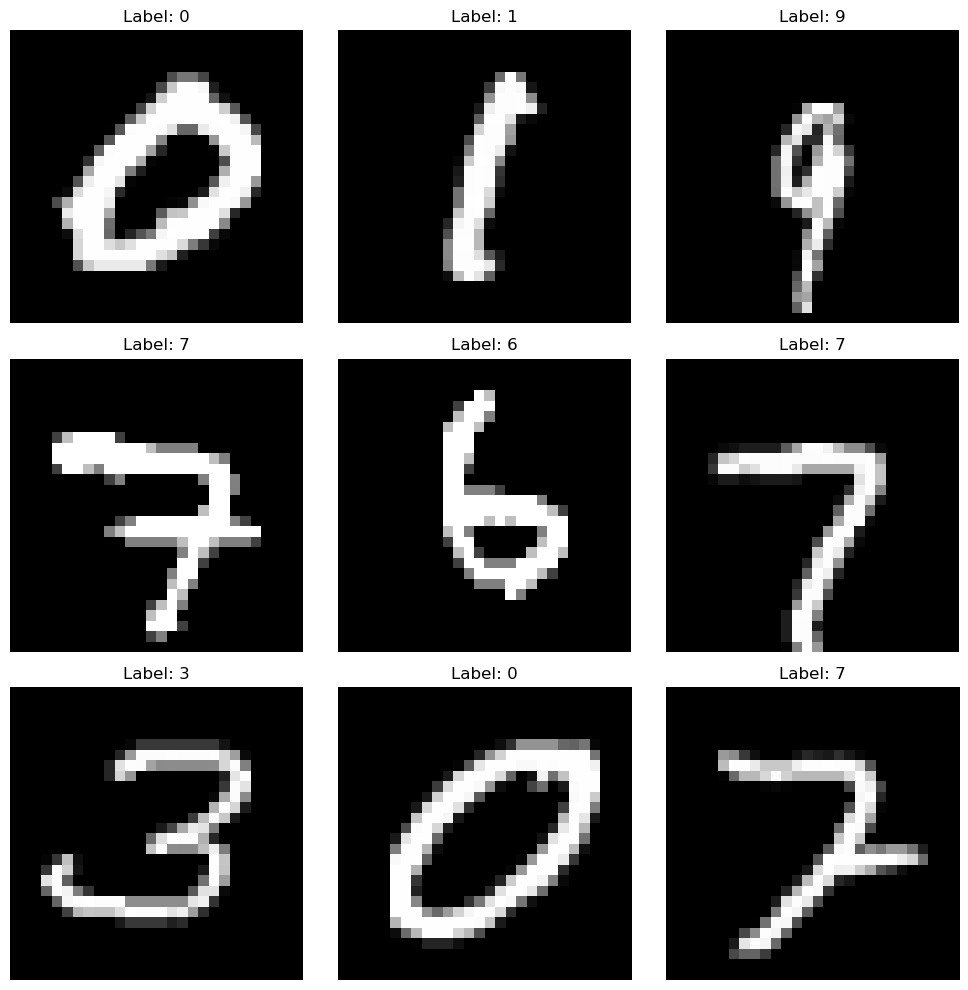

In [309]:
fig, axs = plt.subplots(3,3, figsize=(10,10))

for row in range(3):
    for column in range(3):
        sample_idx = torch.randint(len(train_dataset), size = (1,)).item()
        img, label = train_dataset[sample_idx]
        axs[row, column].imshow(img.squeeze(), cmap='gray')
        axs[row, column].set_title(f"Label: {label}")
        axs[row, column].axis('off')
plt.tight_layout()

## PART 1 : Classification with CNN on MNIST

### Architecture :  LeNet 

LeNet is the architecture described in the pratical session. It is one of the first CNN built by LeCun in the 1990's and proved well on MNIST despite simplicity. The architecture of the NN is the following : 
- Layer 1 : Convolution layer with 6 output channels and 5x5 filter (1x28x28 -> 6x24x24) 
- Layer 2 : Average pool of size 2x2 (6x24x24 -> 6x12x12)
- Layer 3 : Convolution with 16 outplut channels and 5x5 filter (6x12x12 -> 16x8x8)
- Layer 4 : Average pool of size 2x2 (16x8x8 -> 16x4x4 flattened to 256)
- Layer 5 : Fully connected (256 -> 84)
- Layer 6 : Fully connected (84 -> 10)

The activation function are ReLu except for a softmax activation used to output a probability distribution. 


In [122]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # Define layers
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.avgpool1 = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.avgpool2 = nn.AvgPool2d(2, 2)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        # Define the network
        self.net = nn.Sequential(
            self.conv1, nn.ReLU(),
            self.avgpool1,
            self.conv2, nn.ReLU(),
            self.avgpool2, 
            nn.Flatten(),
            self.fc1, nn.ReLU(),
            self.fc2, nn.ReLU(),
            self.fc3,
            nn.Softmax(dim = 1)
        )

    def forward(self, x):
        return self.net(x)


In [123]:
model = LeNet()
model.to(device)
model

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (avgpool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (net): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=256, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
    (12): Softmax(dim=1)
  )
)

### Training and evaluation

We now train the our model on the MNIST dataset using crossentropy loss : $$\mathcal{L}(p_{data},p_\theta) = -\mathbb{E}_{X \sim p_{data}}[\log(p_\theta(X))]$$
Here the model's output on an entry $x$ is the distribution over the labels conditionned on $x$, $p_\theta(c | x)$. The loss compares this output with the onehot distribution of the labeled data.


In [124]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [125]:
epochs = 10
avg_loss_list = []

def train_one_epoch():
    model.train()  # Set model to training mode
    running_loss = 0.0
    total_batches = 0

    for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # Move both to device
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        total_batches += 1
        
    avg_loss = running_loss / total_batches
    avg_loss_list.append(avg_loss)


In [126]:
for epoch in range(epochs):
    train_one_epoch()

100%|██████████| 938/938 [00:06<00:00, 138.32it/s]


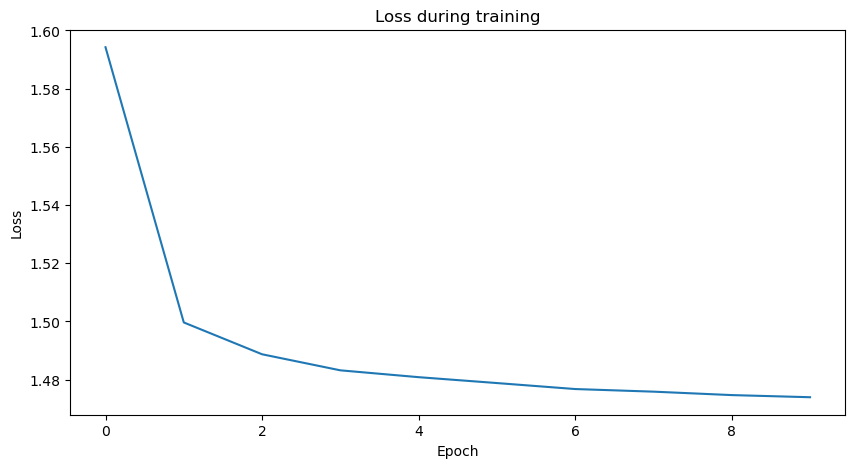

In [127]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(avg_loss_list)
ax.set_title("Loss during training")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
plt.show()


In [128]:
def evaluate(): 
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the 10000 test images: {accuracy:.2f}%')

evaluate()
            

Accuracy of the model on the 10000 test images: 98.71%


## PART 2 : Generation of adverserial examples

### Definition of the method

In this section we implement the Fast Gradient Sign Attack (FGSA) which consist in adding noise to the data in the direction of the directions given by the gradient of the cost function: 
\begin{equation}
    x_{adv}  = x + \epsilon \text{sign}(\nabla_x J(x,y))
\end{equation}
where $\epsilon$ is a parameter to tune.

In [ ]:
def generate_adverserial_examples(model, criterion, image, label, epsilon, batch = True):
    """
    Generate adversarial examples using Fast Gradient Sign Method (FGSM)
    """
    model.eval()
    if not batch : 
        input = image.unsqueeze(0).to(device)  # (1, 1, 28, 28)
        if torch.is_tensor(label):
            target = label.to(device).long().unsqueeze(0) if label.dim() == 0 else label.to(device).long()
        else:
            target = torch.tensor([label], device=device, dtype=torch.long)
    else : 
        input = image.to(device)
        target = label.to(device).long()

    input.requires_grad_(True)
    
    output = model(input)
    loss = criterion(output, target)

    model.zero_grad()
    loss.backward()

    noise = input.grad.sign()
    
    # Create adversarial example
    x_adv = input + epsilon * noise
    x_adv = torch.clamp(x_adv, 0, 1.0)

    if not batch : 
        return x_adv.detach().squeeze(0), noise.detach().squeeze(0)
    else : 
        return x_adv.detach(), noise.detach()


(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

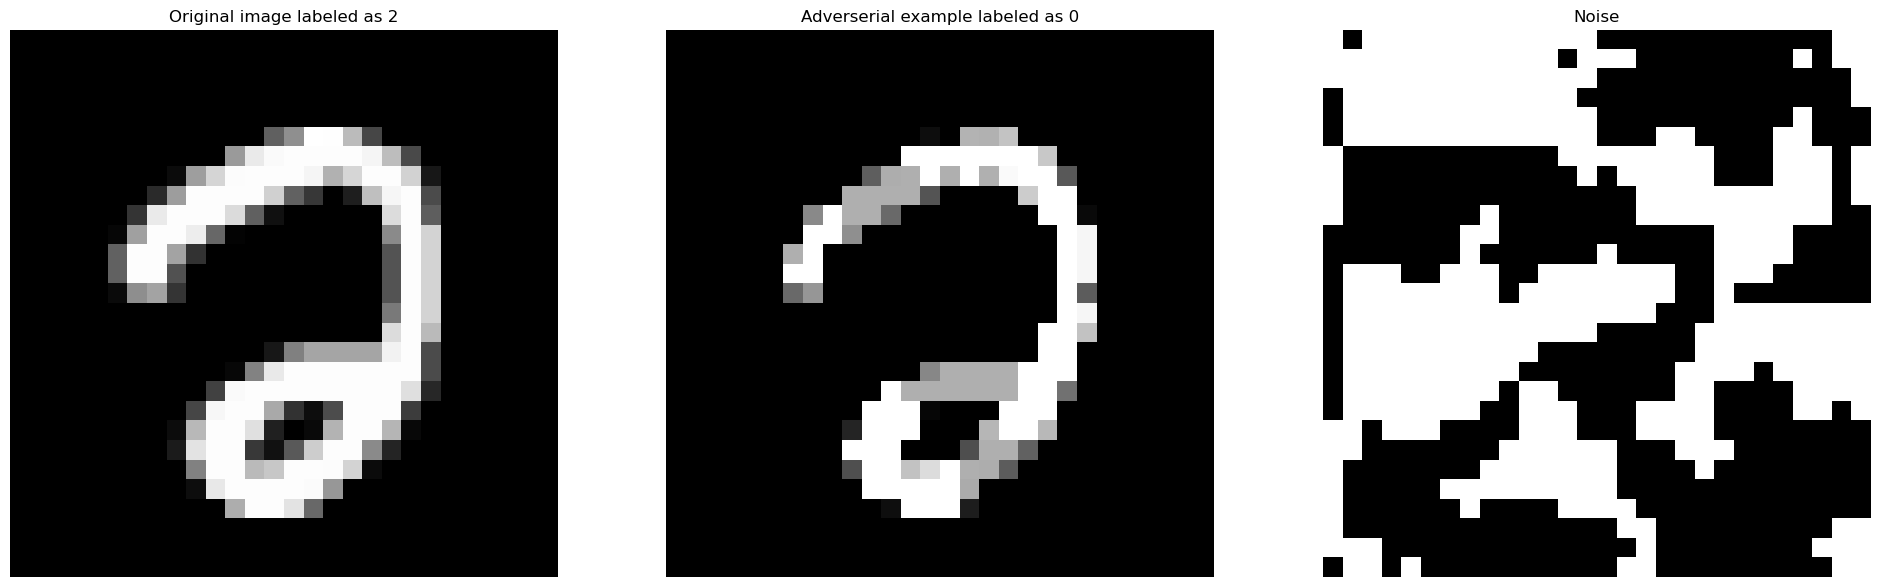

In [305]:
sample_idx = torch.randint(len(test_dataset), size=(1,)).item()
img, label = test_dataset[sample_idx]

img_adv, noise = generate_adverserial_examples(model, criterion, img, label, 0.3, batch = False)

img_adv = img_adv.to(device)
label_adv = torch.argmax(model(img_adv.unsqueeze(0))).item()

fig, axs = plt.subplots(1,3, figsize = (24,12))
axs[0].imshow(img.cpu().squeeze(), cmap='gray')
axs[0].set_title(f"Original image labeled as {label}")
axs[0].axis('off')
axs[1].imshow(img_adv.cpu().squeeze(), cmap='gray')
axs[1].set_title(f"Adverserial example labeled as {label_adv}")
axs[1].axis('off')
axs[2].imshow(noise.cpu().squeeze(), cmap='gray')
axs[2].set_title(f"Noise")
axs[2].axis('off')


Test of the function on a full batch :

Attack success rate: 22.40%


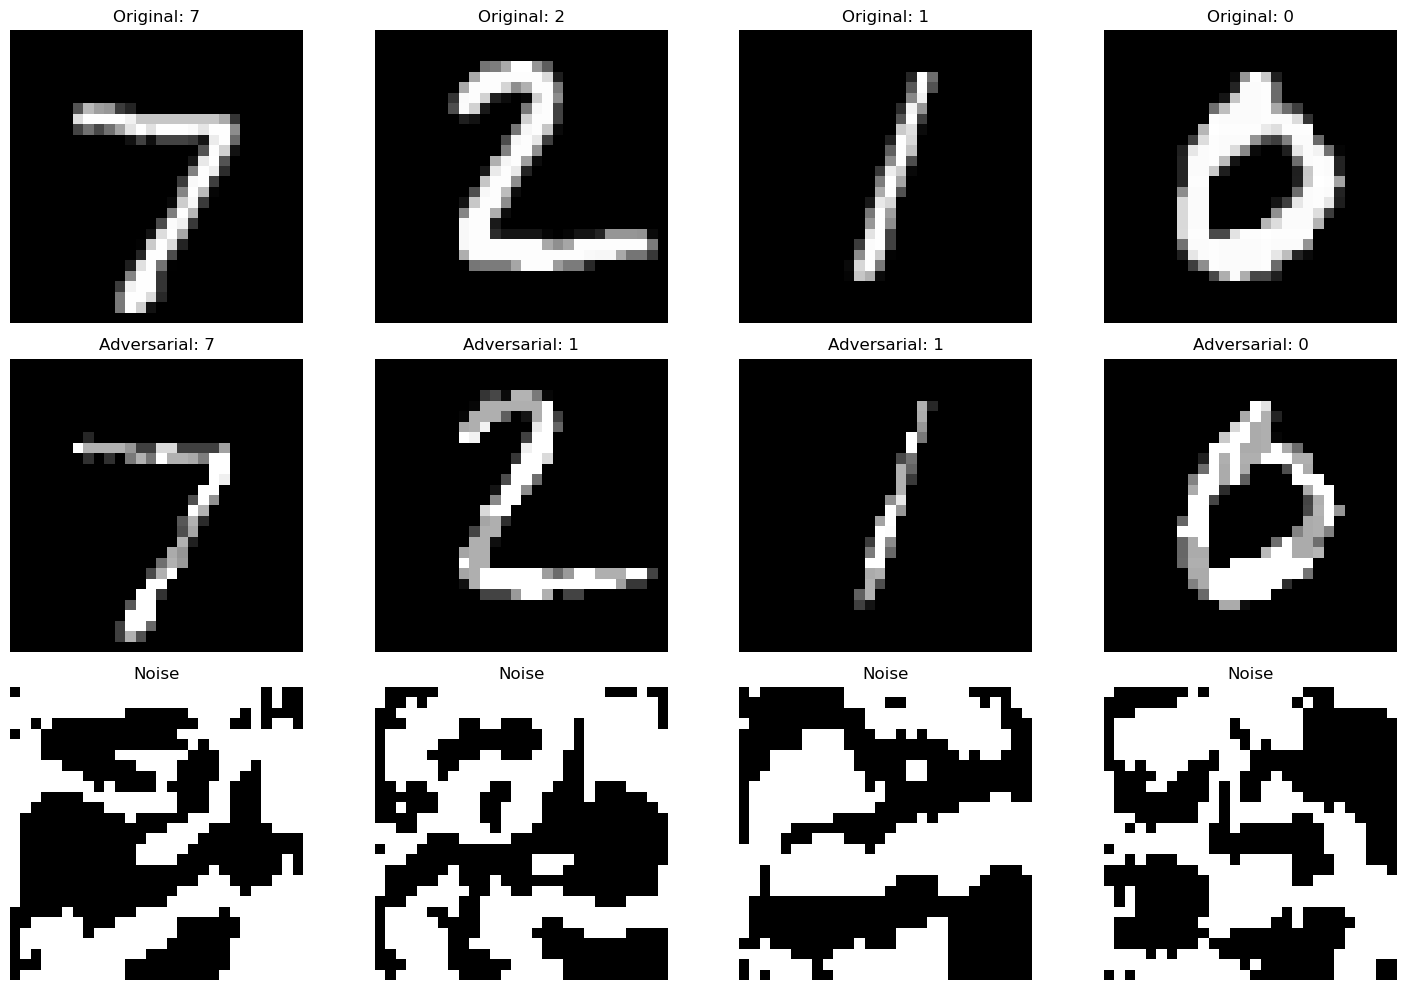

In [ ]:

dataiter = iter(test_loader)
images, labels = next(dataiter)

# Generate adversarial examples for the whole batch
adv_images, noises = generate_adverserial_examples(model, criterion, images, labels, epsilon=0.3, batch=True)

with torch.no_grad():
    orig_outputs = model(images.to(device))
    adv_outputs = model(adv_images.to(device))
    
    orig_preds = torch.argmax(orig_outputs, dim=1)
    adv_preds = torch.argmax(adv_outputs, dim=1)

# Calculate success rate of attack
success_rate = (orig_preds != adv_preds).float().mean().item()
print(f"Attack success rate: {success_rate*100:.2f}%")


fig, axs = plt.subplots(3, 4, figsize=(15, 10))
for i in range(4):
    axs[0,i].imshow(images.cpu()[i].squeeze(), cmap='gray')
    axs[0,i].set_title(f'Original: {labels[i].item()}')
    axs[0,i].axis('off')

    axs[1,i].imshow(adv_images.cpu()[i].squeeze(), cmap='gray')
    axs[1,i].set_title(f'Adversarial: {adv_preds[i].item()}')
    axs[1,i].axis('off')
    
    axs[2,i].imshow(noises.cpu()[i].squeeze(), cmap='gray')
    axs[2,i].set_title('Noise')
    axs[2,i].axis('off')

plt.tight_layout()


### Visualization of $\epsilon$'s influence

Visually, the greater $\epsilon$ is, the more noise is added to the image, the more the image is deteriorated and the les readable is the digit. It also makes the attack easier to detect by sight.

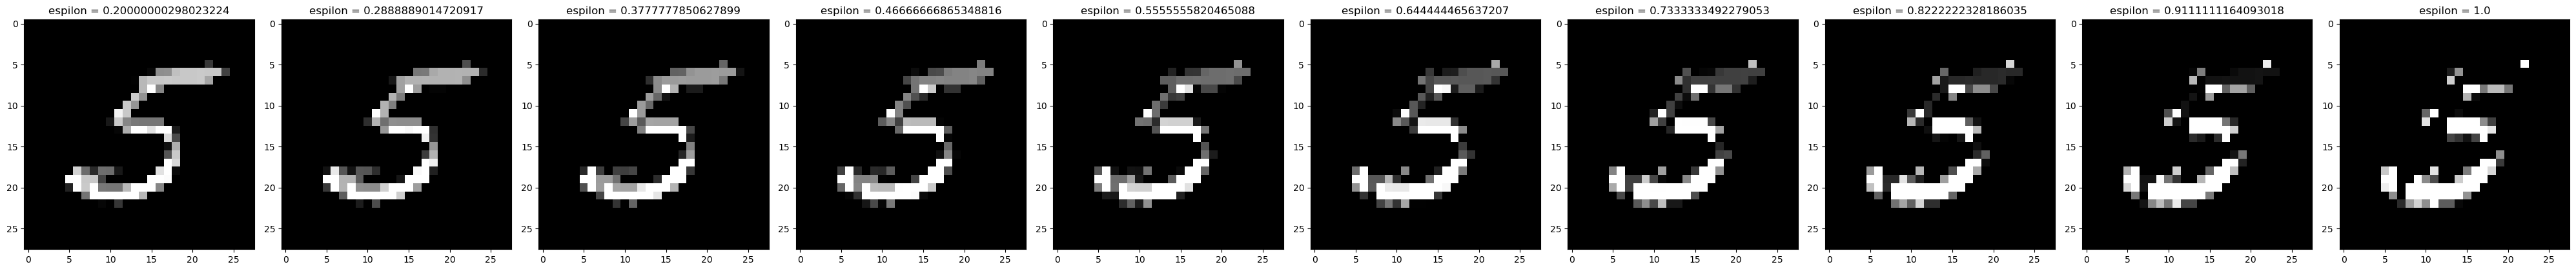

In [334]:
epsilons = torch.linspace(0.2, 1, 10)
sample_idx = torch.randint(len(train_dataset), size = (1,)).item()
image, label = train_dataset[sample_idx]

fig, axs = plt.subplots(1, 10, figsize = (40, 10))

for i in range(len(epsilons)) :
    e = epsilons[i].item() 
    adv_images, _ = generate_adverserial_examples(model, criterion, image, label, e, batch = False)
    axs[i].imshow(adv_images.cpu().squeeze(0), cmap = "gray")
    axs[i].set_title(f"espilon = {e}")
    
plt.tight_layout()


## PART 3 : Statistics on the method

## PART 4 : Training on adverserial examples